<a href="https://colab.research.google.com/github/123wjx123/-/blob/main/Tutorials/PINNs/1_Approximate_a_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
 ! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=01697e5da3a7d7debb07e75e6029208c7d3edb69963afbb93a1ec45b17b1f26c
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [3]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())


cpu


In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


# Tunning Parameters

In [5]:
steps=20000
lr=1e-3

# Functions

In [6]:
def f(x):
    y=torch.sin(x)
    return y
class FCN(nn.Module):

    def __init__(self,layers):
        super().__init__() #call __init__ from parent class

        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')

        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0

        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):

            # weights from a normal distribution with
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)

            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):

            z = self.linears[i](a)

            a = self.activation(z)

        a = self.linears[-1](a)

        return a

    def lossNN(self,x,y):
      loss_val=self.loss_function(self.forward(x),y)
      return loss_val

    def closure(self):

        optimizer.zero_grad()

        loss = self.lossNN(x_train, y_train)

        loss.backward()

        self.iter += 1

        if self.iter % 100 == 0:

            print(loss)

        return loss

# Generate data

In [7]:
# get the analytical solution over the full domain
x = torch.linspace(0,2*np.pi,500).view(-1,1) #prepare to NN
y = f(x)
print(x.shape, y.shape)


torch.Size([500, 1]) torch.Size([500, 1])


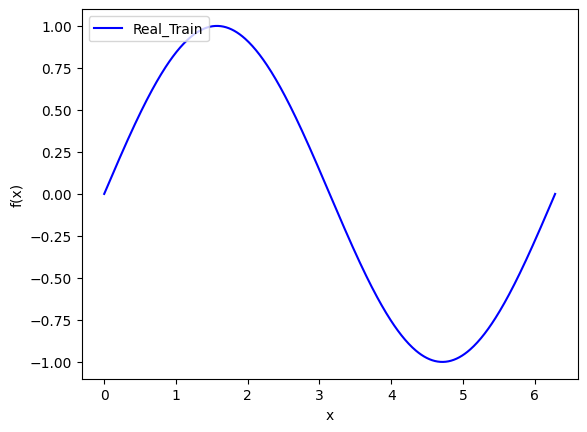

In [16]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
# ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [8]:
indices=np.arange(500)

In [9]:
train_idx,test_idx, _,_ = train_test_split(indices, indices, test_size=0.2, random_state=42)

In [10]:
x_train=x[train_idx]
y_train=y[train_idx]
x_test=x[test_idx]
y_test=y[test_idx]

# Train Neural Network

In [13]:
torch.manual_seed(123)
x_train=x_train.float().to(device)
y_train=y_train.float().to(device)
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
model = FCN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [14]:
for i in range(steps):
    optimizer.zero_grad()
    yh = model(x_train)
    loss = model.lossNN(x_train,y_train)# use mean squared error
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(0.6415, grad_fn=<MseLossBackward0>)
tensor(1.0652e-05, grad_fn=<MseLossBackward0>)
tensor(5.1237e-05, grad_fn=<MseLossBackward0>)
tensor(3.5572e-06, grad_fn=<MseLossBackward0>)
tensor(2.9634e-06, grad_fn=<MseLossBackward0>)
tensor(2.9643e-06, grad_fn=<MseLossBackward0>)
tensor(1.6893e-05, grad_fn=<MseLossBackward0>)
tensor(2.5401e-05, grad_fn=<MseLossBackward0>)
tensor(4.0385e-05, grad_fn=<MseLossBackward0>)
tensor(9.8683e-05, grad_fn=<MseLossBackward0>)


In [ ]:
print(model.lossNN(x_test.float().to(device),y_test.float().to(device)))

tensor(7.2382e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [15]:
yh=model(x_train)
yh_test=model(x_test.float().to(device))

In [ ]:
_,indices2=torch.sort(x_train.squeeze(1))
_,indices3=torch.sort(x_test.squeeze(1))

In [ ]:
x_train_plot=x_train[indices2]
y_train_plot=y_train[indices2]
yh_plot=yh[indices2]
x_test_plot=x_test[indices3]
y_test_plot=y_test[indices3]
yh_test_plot=yh_test[indices3]

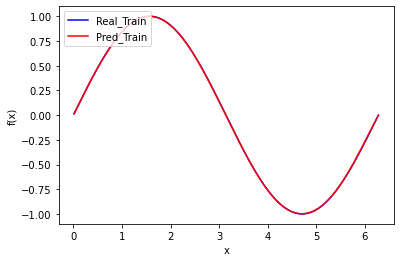

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(x_train_plot.detach().cpu().numpy(),y_train_plot.detach().cpu().numpy(),color='blue',label='Real_Train')
ax1.plot(x_train_plot.detach().cpu().numpy(),yh_plot.detach().cpu().numpy(),color='red',label='Pred_Train')
#ax1.plot(x_test_plot.detach().numpy(),y_test_plot.detach().numpy(),color='green',label='Real_Test')
#ax1.plot(x_test_plot.detach().numpy(),yh_test_plot.detach().numpy(),color='orange',label='Pred_Test')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

In [ ]:
torch.max(x_train)

tensor(6.2832, device='cuda:0')